In [1]:
import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style, colors
# import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to enable jupyter ipython widgets run following line at command line
# jupyter nbextension enable --py widgetsnbextension
# to import ipywidgets in jupyter notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


# constants

In [2]:
# master_table = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_Cervical_Master_Patient_Table_V2_20190611.xls'
master_table = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_Cervical_Master_Patient_Table_V6_20190813.xlsx'
mut = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/118_patients_strelka_snvs_indels_counts_20190515.txt'
mut = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/118_patients_strelka_snvs_indels_counts_20190617.txt'

In [3]:
muts = pd.read_csv(mut, sep='\t', usecols=['patient', 'strelka_mutations'])
muts.set_index('patient', inplace=True)
muts.head(2)

,strelka_mutations
patient,
HTMCP-03-06-02001,26974
HTMCP-03-06-02002,16661


In [4]:

master = pd.read_excel(master_table, sep='\t', index_col='Patient')
master = master[master.Cohort == 'Discovery']
master.head(2)
master.shape
master['Final histology'].unique()
master['Grade'].unique()
master['Stage'].unique()
# master[''].unique()

,Cohort,HIV status,HAART therapy prior to dx,Stage,Grade,Histology from clinical data,Final histology,Pathology comment,Age,CD4 counts at diagnosis,...,Signature13_APOBEC (nnls),Max APOBEC score,CD8 T-cells,CD4 T-cells,T-cell content,Cibersort p-value,DNA methylation clusters,RNA-Seq clusters,HRD score,Tumour content
Patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,Discovery,Positive,YES,Stage IIB,G2,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,56.0,337.0,...,0.236,0.316,0.043,0.229,0.272,0.0,NaN,NaN,6.0,55.0
HTMCP-03-06-02002,Discovery,Negative,NaN,Stage IB1,G3,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,62.0,NaN,...,0.133,0.260,0.217,0.322,0.648,0.2,NaN,NaN,10.0,70.0


(118, 25)

array(['Squamous', 'Neuroendocrine', 'Adenocarcinoma', 'Adenosquamous',
       'Undifferentiated'], dtype=object)

array(['G2', 'G3', 'G1', nan], dtype=object)

array(['Stage IIB', 'Stage IB1', 'Stage IB2', 'Stage IIIB', 'Stage IIA2',
       'Stage IIIA', 'Stage IVB', 'Stage IVA', 'Stage IIA1', 'Stage IIA',
       nan], dtype=object)

In [33]:
master.columns

Index(['Cohort', 'HIV status', 'HAART therapy prior to dx', 'Stage', 'Grade',
       'Histology from clinical data', 'Final histology', 'Pathology comment',
       'Age', 'CD4 counts at diagnosis', 'HPV type', 'Integration',
       'HPV clade', 'Coding mutation rate (Mb)', 'Signature2_APOBEC (nnls)',
       'Signature13_APOBEC (nnls)', 'Max APOBEC score', 'CD8 T-cells',
       'CD4 T-cells', 'T-cell content', 'Cibersort p-value',
       'DNA methylation clusters', 'RNA-Seq clusters', 'HRD score',
       'Tumour content'],
      dtype='object')

In [35]:
master['Coding mutation rate (Mb)']

Patient
HTMCP-03-06-02001     3.151715
HTMCP-03-06-02002     2.172708
HTMCP-03-06-02003     0.841602
HTMCP-03-06-02006     2.559158
HTMCP-03-06-02008     0.833015
HTMCP-03-06-02012     5.169843
HTMCP-03-06-02013     1.073472
HTMCP-03-06-02020     2.301525
HTMCP-03-06-02036     0.755725
HTMCP-03-06-02037     1.279579
HTMCP-03-06-02040     1.829197
HTMCP-03-06-02042     3.881676
HTMCP-03-06-02046     0.429389
HTMCP-03-06-02047     1.116411
HTMCP-03-06-02054     2.155533
HTMCP-03-06-02057     0.661259
HTMCP-03-06-02058    17.699413
HTMCP-03-06-02063    23.041012
HTMCP-03-06-02068     5.470415
HTMCP-03-06-02070     1.889311
HTMCP-03-06-02071     0.721373
HTMCP-03-06-02074     1.614503
HTMCP-03-06-02075     4.268126
HTMCP-03-06-02076     1.726144
HTMCP-03-06-02089     1.975189
HTMCP-03-06-02092     1.262404
HTMCP-03-06-02097     0.884541
HTMCP-03-06-02098     2.395990
HTMCP-03-06-02099     0.961831
HTMCP-03-06-02103     7.248086
                       ...    
HTMCP-03-06-02268     2.224235


In [34]:
master.shape

(118, 25)

# mutation load HIV+ vs -

In [5]:
dfm = pd.merge(master, muts, left_index=True, right_index=True)

In [6]:
dfm.head(2)
dfm.shape

,Cohort,HIV status,HAART therapy prior to dx,Stage,Grade,Histology from clinical data,Final histology,Pathology comment,Age,CD4 counts at diagnosis,...,Max APOBEC score,CD8 T-cells,CD4 T-cells,T-cell content,Cibersort p-value,DNA methylation clusters,RNA-Seq clusters,HRD score,Tumour content,strelka_mutations
HTMCP-03-06-02001,Discovery,Positive,YES,Stage IIB,G2,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,56.0,337.0,...,0.316,0.043,0.229,0.272,0.0,NaN,NaN,6.0,55.0,26974
HTMCP-03-06-02002,Discovery,Negative,NaN,Stage IB1,G3,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,62.0,NaN,...,0.260,0.217,0.322,0.648,0.2,NaN,NaN,10.0,70.0,16661


(118, 26)

In [7]:
dfs = dfm[['HIV status', 'strelka_mutations', 'Coding mutation rate (Mb)']]
dfs.head(2)

,HIV status,strelka_mutations,Coding mutation rate (Mb)
HTMCP-03-06-02001,Positive,26974,3.151715
HTMCP-03-06-02002,Negative,16661,2.172708


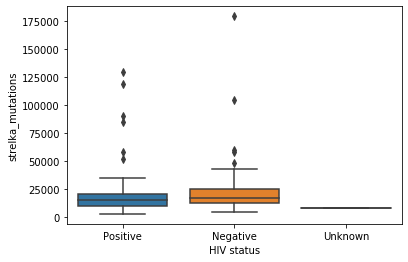

In [14]:
sns.boxplot('HIV status',  'strelka_mutations', data=dfs)

In [22]:
neg = dfs[dfs['HIV status'] == 'Negative']['Coding mutation rate (Mb)']
pos = dfs[dfs['HIV status'] == 'Positive']['Coding mutation rate (Mb)']
stats.ttest_ind(neg, pos)


Ttest_indResult(statistic=1.0446605517945173, pvalue=0.2983708126695581)

In [20]:
other

Series([], Name: Coding mutation rate (Mb), dtype: float64)

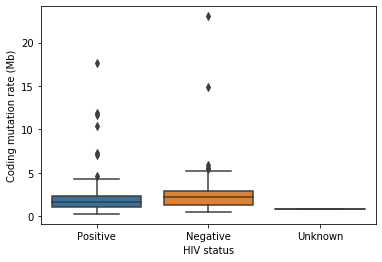

In [15]:
sns.boxplot('HIV status',  'Coding mutation rate (Mb)', data=dfs)

In [23]:
neg = dfs[dfs['HIV status'] == 'Negative']['strelka_mutations']
pos = dfs[dfs['HIV status'] == 'Positive']['strelka_mutations']
stats.ttest_ind(neg, pos)

Ttest_indResult(statistic=1.0204149396565811, pvalue=0.3096735750987968)

In [24]:
dfs.shape

(118, 3)

### association between clads and SMGs

In [7]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/smgs.txt'
smgs = pd.read_csv(f, header=None)[0].tolist()
smgs

['PIK3CA',
 'FAT1',
 'MLL2',
 'FBXW7',
 'CASP8',
 'SLC35G5',
 'MAPK1',
 'PCDHGA12',
 'PSPC1',
 'ZNF750',
 'PCDHA9',
 'ZC3H6']

In [28]:
mutations_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/somatic_mutation_gene_by_patient_summary_20190529.tsv'
muts = pd.read_csv(mutations_f, sep='\t')
muts = muts[muts.gene.isin(smgs)].set_index('gene').T.reset_index()
muts.head(2)

gene,index,CASP8,FAT1,FBXW7,MAPK1,MLL2,PCDHA9,PCDHGA12,PIK3CA,PSPC1,SLC35G5,ZC3H6,ZNF750
0,HTMCP-03-06-02001,mutated,wt,wt,wt,wt,wt,wt,mutated,wt,wt,wt,wt
1,HTMCP-03-06-02002,wt,wt,wt,wt,mutated,wt,wt,mutated,mutated,wt,wt,mutated


In [33]:
muts.columns

Index(['index', 'CASP8', 'FAT1', 'FBXW7', 'MAPK1', 'MLL2', 'PCDHA9',
       'PCDHGA12', 'PIK3CA', 'PSPC1', 'SLC35G5', 'ZC3H6', 'ZNF750'],
      dtype='object', name='gene')

In [36]:
muts = pd.melt(muts, id_vars='index', value_vars=muts.columns.tolist()[1:], value_name='mutated')

In [38]:
muts.set_index('index', inplace=True)
muts.head(2)

,gene,mutated
index,,
HTMCP-03-06-02001,CASP8,mutated
HTMCP-03-06-02002,CASP8,wt


In [17]:
df = master[['HPV clade']]
df.head(2)

,HPV clade
Patient,
HTMCP-03-06-02001,A9
HTMCP-03-06-02002,A9


In [85]:
dfm = muts.merge(df, left_index=True, right_index=True).reset_index()
dfm.head()

,index,gene,mutated,HPV clade
0,HTMCP-03-06-02001,CASP8,mutated,A9
1,HTMCP-03-06-02001,FAT1,wt,A9
2,HTMCP-03-06-02001,FBXW7,wt,A9
3,HTMCP-03-06-02001,MAPK1,wt,A9
4,HTMCP-03-06-02001,MLL2,wt,A9


In [94]:
dfm1 = pd.pivot_table(dfm, index='HPV clade', columns='mutated', values='gene', aggfunc=lambda x: ';'.join([str(v) for v in set(x)]))

In [105]:
def count_wt(x):
    return (x=='wt').sum()
def count_mut(x):
    return (x=='mutated').sum()

In [130]:
df1 = pd.pivot_table(dfm, values='mutated', index=['HPV clade'], columns='gene', aggfunc=[count_wt, count_mut])
df2 = df1.swaplevel(axis=1)
df2
df2.sort_index(axis=1)

gene,CASP8,FAT1,FBXW7,MAPK1,MLL2,PCDHA9,PCDHGA12,PIK3CA,PSPC1,SLC35G5,...,FBXW7,MAPK1,MLL2,PCDHA9,PCDHGA12,PIK3CA,PSPC1,SLC35G5,ZC3H6,ZNF750
,count_wt,count_wt,count_wt,count_wt,count_wt,count_wt,count_wt,count_wt,count_wt,count_wt,...,count_mut,count_mut,count_mut,count_mut,count_mut,count_mut,count_mut,count_mut,count_mut,count_mut
HPV clade,,,,,,,,,,,,,,,,,,,,,
A7,51,41,50,51,43,52,49,35,48,47,...,2,1,9,0,3,17,4,5,1,2
A9,51,47,47,54,51,53,53,36,55,54,...,10,3,6,4,4,21,2,3,3,3
Other,8,8,9,7,7,9,9,6,9,9,...,0,2,2,0,0,3,0,0,0,0


gene          CASP8               FAT1              FBXW7              MAPK1  \
          count_mut count_wt count_mut count_wt count_mut count_wt count_mut   
HPV clade                                                                      
A7                1       51        11       41         2       50         1   
A9                6       51        10       47        10       47         3   
Other             1        8         1        8         0        9         2   

gene                    MLL2           ...    PIK3CA              PSPC1  \
          count_wt count_mut count_wt  ... count_mut count_wt count_mut   
HPV clade                              ...                                
A7              51         9       43  ...        17       35         4   
A9              54         6       51  ...        21       36         2   
Other            7         2        7  ...         3        6         0   

gene                 SLC35G5              ZC3H6             ZNF750           
          count_wt count_mut count_wt count_mut count_wt count_mut count_wt  
HPV clade                                                                    
A7              48         5       47         1       51         2       50  
A9              55         3       54         3       54         3       54  
Other            9         0        9         0        9         0        9  

[3 rows x 24 columns]

In [131]:
for gene in smgs:
    dftmp = dfm[dfm.gene == gene]
#     pd.pivot_table(dftmp, index='HPV clade', columns='mutated',aggfunc='count')
    df2 = pd.crosstab(index=dftmp['mutated'], columns=dftmp['HPV clade'])#, normalize='columns')
    df2.columns.name = gene
    df2.index.name = ''
    oddsratio, pvalue = stats.fisher_exact([df2.iloc[0, :2], df2.iloc[1, :2]])
#     print(gene, pvalue)
#     df2
#     dftmp.groupby('HPV clade').count()

In [6]:
df = master[['HPV clade','Coding mutation rate (Mb)']]
df.head(2)

,HPV clade,Coding mutation rate (Mb)
Patient,,
HTMCP-03-06-02001,A9,3.151715
HTMCP-03-06-02002,A9,2.172708


In [26]:
dfm = df.merge(muts, left_index=True, right_index=True)
dfm.head()

,HPV clade,Coding mutation rate (Mb),strelka_mutations
HTMCP-03-06-02001,A9,3.151715,26974
HTMCP-03-06-02002,A9,2.172708,16661
HTMCP-03-06-02003,A9,0.841602,8397
HTMCP-03-06-02006,A7,2.559158,21697
HTMCP-03-06-02008,Other,0.833015,8082


In [29]:
A9 = dfm[dfm['HPV clade'] == 'A9']['strelka_mutations']
A7 = dfm[dfm['HPV clade'] == 'A7']['strelka_mutations']
other = dfm[dfm['HPV clade'] == 'Other']['strelka_mutations']
stats.ttest_ind(A9, A7)
stats.ttest_ind(A9, other)
stats.ttest_ind(A7, other)

Ttest_indResult(statistic=0.04802591604758524, pvalue=0.9617851160883055)

Ttest_indResult(statistic=0.6290799398338686, pvalue=0.531535807688768)

Ttest_indResult(statistic=0.7873487647281108, pvalue=0.4342293443930816)

Text(0.5,1,'Coding Mutation Rate: HPV clade')

Text(0.5,0,'HPV clade')

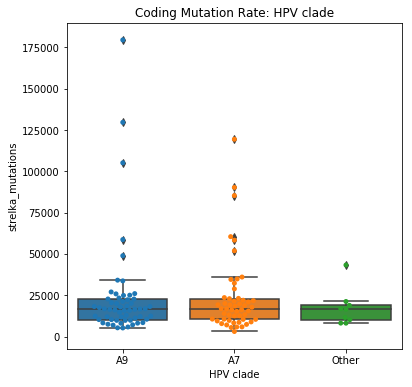

In [27]:

# plt.boxplot(dfm['HPV clade'], dfm['strelka_mutations'])
f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(dfm['HPV clade'], dfm['strelka_mutations'], ax=ax)
sns.swarmplot(dfm['HPV clade'], dfm['strelka_mutations'], ax=ax)
ax.set_title('Coding Mutation Rate: HPV clade')
ax.set_xlabel('HPV clade')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/coding_mutation_rate_HPV clade_groups.pdf'
# plt.savefig(of, dpi=200, bbox_inches='tight')

Text(0.5,1,'Coding Mutation Rate: HPV clade')

Text(0.5,0,'HPV clade')

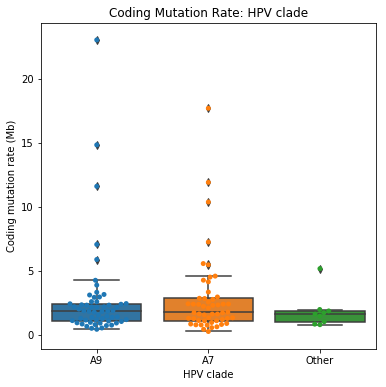

In [30]:
# plt.boxplot(df['HPV clade'], df['Coding mutation rate (Mb)'])
f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(df['HPV clade'], df['Coding mutation rate (Mb)'], ax=ax)
sns.swarmplot(df['HPV clade'], df['Coding mutation rate (Mb)'], ax=ax)
ax.set_title('Coding Mutation Rate: HPV clade')
ax.set_xlabel('HPV clade')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/coding_mutation_rate_HPV clade_groups.pdf'
plt.savefig(of, dpi=200, bbox_inches='tight')

In [14]:
A9 = df[df['HPV clade'] == 'A9']['Coding mutation rate (Mb)']
A7 = df[df['HPV clade'] == 'A7']['Coding mutation rate (Mb)']
other = df[df['HPV clade'] == 'Other']['Coding mutation rate (Mb)']

stats.ttest_ind(A9, A7)
stats.ttest_ind(A9, other)
stats.ttest_ind(A7, other)

Ttest_indResult(statistic=-0.09377163712474476, pvalue=0.9254659280879265)

Ttest_indResult(statistic=0.7128776025496105, pvalue=0.4785127147282737)

Ttest_indResult(statistic=0.8977080231017319, pvalue=0.37299000761317247)

# APOBEC score

In [8]:
df = master[['Max APOBEC score','Coding mutation rate (Mb)']]
# df['apobec'] = df['Max APOBEC score'].map({})
df.head(2)

,Max APOBEC score,Coding mutation rate (Mb)
Patient,,
HTMCP-03-06-02001,0.316,3.151715
HTMCP-03-06-02002,0.260,2.172708


In [9]:
df['apobec'] = (df['Max APOBEC score'] > 0.4).map({True: '> 0.4', False: '<= 0.4'})

/projects/da_workspace/software/miniconda/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.head()

,Max APOBEC score,Coding mutation rate (Mb),apobec
Patient,,,
HTMCP-03-06-02001,0.3160,3.151715,<= 0.4
HTMCP-03-06-02002,0.2600,2.172708,<= 0.4
HTMCP-03-06-02003,0.0607,0.841602,<= 0.4
HTMCP-03-06-02006,0.1690,2.559158,<= 0.4
HTMCP-03-06-02008,0.0848,0.833015,<= 0.4


In [18]:
df[df.apobec == '<= 0.4'].count()
df[df.apobec == '> 0.4'].count()
df.apobec.unique()

Max APOBEC score             99
Coding mutation rate (Mb)    99
apobec                       99
dtype: int64

Max APOBEC score             19
Coding mutation rate (Mb)    19
apobec                       19
dtype: int64

array(['<= 0.4', '> 0.4'], dtype=object)

In [29]:
df[df.apobec == '> 0.4']['Coding mutation rate (Mb)'].median()

4.58587417814307

Text(0.5,1,'Coding Mutation Rate: APOBEC')

Text(0.5,0,'APOBEC')

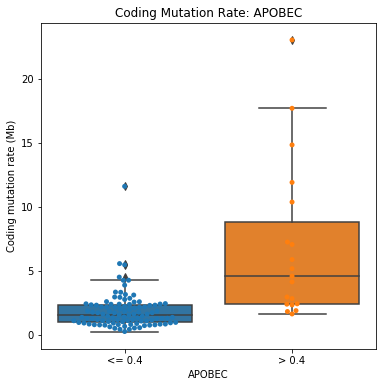

In [16]:
# plt.boxplot(df['apobec'], df['Coding mutation rate (Mb)'])
f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(df['apobec'], df['Coding mutation rate (Mb)'], ax=ax)
sns.swarmplot(df['apobec'], df['Coding mutation rate (Mb)'], ax=ax)
ax.set_title('Coding Mutation Rate: APOBEC')
ax.set_xlabel('APOBEC')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/coding_mutation_rate_apobec_groups.pdf'
plt.savefig(of, dpi=200, bbox_inches='tight')

In [30]:
a = df[df['Max APOBEC score'] > 0.4]['Coding mutation rate (Mb)']
b = df[df['Max APOBEC score'] <= 0.4]['Coding mutation rate (Mb)']

stats.ttest_ind(a, b)

Ttest_indResult(statistic=7.264896547145843, pvalue=4.651494895899535e-11)

In [32]:
a.mean()
a.median()
b.mean()
b.median()

6.854403894297233

4.585874178143075

1.871441938471961

1.554388064127147

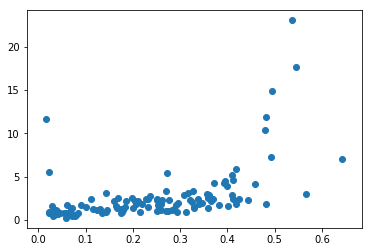

In [12]:
plt.scatter(master['Max APOBEC score'], master['Coding mutation rate (Mb)'])